# Assignment 5: Link Analysis

In this assignment, we will use network-based algorithms, such as PageRank, to improve our search results. After the last assignment on evaluating IR systems, we go back to our PubMed dataset of scientific papers. In this dataset, we look at two graphs in particular: the co-authorship network and the citation network.

The citation network is similar to the link network of the web: Citations are like web links pointing to other documents. We can therefore apply the same network-based ranking methods.

## Code from previous assignments

In [91]:
import pickle, bz2
from collections import defaultdict, namedtuple, Counter
from math import log10, sqrt
from IPython.display import display, HTML
import matplotlib.pyplot as plt

# show plots inline within the notebook
%matplotlib inline
# set plots' resolution
plt.rcParams['savefig.dpi'] = 100

In [2]:
Ids_file = 'data/allergy_Ids.pkl.bz2'
Summaries_file = 'data/allergy_Summaries.pkl.bz2'
Citations_file = 'data/allergy_Citations.pkl.bz2'
Abstracts_file = 'data/allergy_Abstracts.pkl.bz2'

Ids = pickle.load( bz2.BZ2File( Ids_file, 'rb' ) )
Summaries = pickle.load( bz2.BZ2File( Summaries_file, 'rb' ) )
Citations = pickle.load( bz2.BZ2File( Citations_file, 'rb' ) )
Abstracts = pickle.load( bz2.BZ2File( Abstracts_file, 'rb' ) )

paper = namedtuple( 'paper', ['title', 'authors', 'year', 'doi'] )

for (id, paper_info) in Summaries.items():
    Summaries[id] = paper( *paper_info )

In [3]:
def display_summary( id, show_abstract=False, show_id=True, extra_text='' ):
    """
    Function for printing a paper's summary through IPython's Rich Display System.
    Trims long author lists, and adds a link to the paper's DOI (when available).
    """
    s = Summaries[id]
    lines = []
    title = s.title
    if s.doi != '':
        title = '<a href=http://dx.doi.org/{:s}>{:s}</a>'.format(s.doi, title)
    title = '<strong>' + title + '</strong>'
    lines.append(title)
    authors = ', '.join( s.authors[:20] ) + ('' if len(s.authors) <= 20 else ', ...')
    lines.append(str(s.year) + '. ' + authors)
    if (show_abstract):
        lines.append('<small><strong>Abstract:</strong> <em>{:s}</em></small>'.format(Abstracts[id]))
    if (show_id):
        lines.append('[ID: {:d}]'.format(id))
    if (extra_text != ''):
         lines.append(extra_text)
    display( HTML('<br>'.join(lines)) )

In [4]:
def tokenize(text):
    return text.split(' ')

def preprocess(tokens):
    result = []
    for token in tokens:
        result.append(token.lower())
    return result

In [5]:
inverted_index = defaultdict(set)

for (id, abstract) in Abstracts.items():
    for term in preprocess(tokenize(abstract)):
        inverted_index[term].add(id)

tf_matrix = defaultdict(Counter)

for (doc_id, abstract) in Abstracts.items():
    tokens = preprocess(tokenize(abstract))
    tf_matrix[doc_id] = Counter(tokens)

def tf(t,d):
    return float(tf_matrix[d][t])

def df(t):
    return float(len(inverted_index[t]))

num_documents = float(len(Abstracts))

def idf(t):
    return log10((num_documents + 1)/(df(t) + 1))

def tfidf(t,d):
    return tf(t,d) * idf(t)

## Co-authorship network

We start by building a mapping from authors to the set of identifiers of papers they authored.  We'll be using Python sets again for that purpose.

In [6]:
papers_of_author = defaultdict(set)

for (id, p) in Summaries.items():
    for a in p.authors:
        papers_of_author[a].add(id)

Let's try it out:

In [7]:
papers_of_author['Chawla A']

{21436399, 24037376}

In [8]:
for id in papers_of_author['Chawla A']:
    display_summary(id)

We can now build a co-authorship network, that is a graph linking authors to the set of co-authors they have published with:

In [9]:
coauthors = defaultdict(set)

for p in Summaries.values():
    for a in p.authors:
        coauthors[a].update(p.authors)

# The code above results in each author being listed as having co-authored with himself/herself.
# We remove these self-references here:
for (a, ca) in coauthors.items():
    ca.remove(a)

And let's try it out again:

In [10]:
print(', '.join( coauthors['Chawla A'] ))

Nussbaum JC, Jouihan HA, Bando JK, Mohapatra A, Wu D, Thornton EE, Ricardo-Gonzalez RR, Locksley RM, von Moltke J, Liang HE, Van Dyken SJ, Molofsky AB, Cheng LE, Krummel MF


Unlike a citation or link network, the edges of this co-authorship network are not directed: There is no direction (no arrow) in the link between author 'Chawla A' and 'Thornton EE', for example. With our chosen implementation, each of these links in fact appears twice in our data, as we also get 'Chawla A' as co-author when we look for 'Thornton EE':

In [11]:
print(', '.join( coauthors['Thornton EE'] ))

Nussbaum JC, Chawla A, Mohapatra A, Locksley RM, von Moltke J, Liang HE, Van Dyken SJ, Molofsky AB, Cheng LE, Krummel MF


With that in mind, we can calculate some basic statistics about our graph:

In [12]:
print('Number of nodes (authors): ', len(coauthors))

# We divide by two here to account for the fact that each edge is represented twice (see above):
coauthor_rel_count = int(sum( len(c) for c in coauthors.values() ) / 2)
print('Number of links (co-authorship relations): ', coauthor_rel_count)

Number of nodes (authors):  137755
Number of links (co-authorship relations):  961501


With this data at hand, we can plot the [degree distribution](https://en.wikipedia.org/wiki/Degree_distribution) by showing the number of collaborators a scientist has published with:

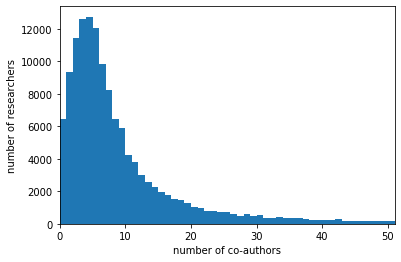

In [13]:
plt.hist( x=[ len(ca) for ca in coauthors.values() ], bins=range(60) )
plt.xlabel('number of co-authors')
plt.ylabel('number of researchers')
plt.xlim(0,51);

Now that we have explored this network, let's move to the citation network.

## Citations network

Next, we can look at the citation network. In contrast to the co-authorship network, the citation network is a _directed_ network, where edges can be drawn as arrows. We'll start by expanding the our data about citations into two mappings: 

* `papers_citing[id]`: papers citing a given paper
* `cited_by[id]`: papers cited by a given paper (in other words: its list of references)

`papers_citing` will give us the list of a node's incoming links, whereas `cited_by` will give us the list of its outgoing links.

In [14]:
papers_citing = Citations  # no changes needed, this is what we are storing already in the Citations dataset

cited_by = defaultdict(list)

for ref, papers_citing_ref in papers_citing.items():
    for id in papers_citing_ref:
        cited_by[ id ].append( ref )

As we are dealing with a subset of the data (the papers mentioning "allergy"), `papers_citing` can contain references to papers outside of our subset. On the other hand, the way we created `cited_by`, it will only contain backward references from within our dataset, meaning that it is incomplete with respect to the whole dataset. Nethertheless, we can use this citation network on our subset of allergy-related papers to implement link analysis techniques.

Let us now look at an exemplary paper, let's say the one with identifier 23917667. We can now use the `cited_by` mapping to retrieve its (incomplete) list of references:

In [15]:
paper_id = 23917667
refs = { id : Summaries[id].title for id in cited_by[paper_id] }
print(len(refs), 'references found for paper', paper_id)
refs

12 references found for paper 23917667


{21771119: 'The role of genetics and environment in the rise of childhood food allergy.',
 21624746: 'Association between genes encoding components of the IL-10/IL-0 receptor pathway and asthma in children.',
 18440625: 'Dust mite exposure modifies the effect of functional IL10 polymorphisms on allergy and asthma exacerbations.',
 17935766: "The natural history of IgE-mediated cow's milk allergy.",
 17121586: 'Influence of SNPs in cytokine-related genes on the severity of food allergy and atopic eczema in children.',
 16373958: "Cow's milk allergy: a complex disorder.",
 16310526: 'Adverse reactions to foods.',
 15864084: 'Genetic and environmental risk factors for the development of food allergy.',
 15131577: "Cow's milk-specific T-cell reactivity of children with and without persistent cow's milk allergy: key role for IL-10.",
 14748015: 'IL10 gene polymorphisms are associated with asthma phenotypes in children.',
 12884306: 'Reduced transforming growth factor-beta1-producing T cells

If we lookup the same paper in `papers_citing`, we now see that some of the cited papers are themselves in our dataset, but others are not (shown below as `'??'`):

In [16]:
{ id : Summaries.get(id,['??'])[0]  for id in papers_citing[paper_id] }

{27070332: 'Are genetic tests informative in predicting food allergy?',
 26516307: '??',
 25721048: '??',
 25238536: '??'}

Paper 26516307, for example, is not in our dataset and we do not have any direct information about it, but its repeated occurrence in other papers' citation lists does allow us to reconstruct some of its references. Below is the list of papers in our dataset cited by that paper:

In [17]:
paper_id2 = 26516307
refs2 = { id : Summaries[id].title for id in cited_by[paper_id2] }
print(len(refs2), 'references identified for the paper with id', paper_id2)
refs2

4 references identified for the paper with id 26516307


{23917667: "Interleukin 10 (IL10) and transforming growth factor β1 (TGFβ1) gene polymorphisms in persistent IgE-mediated cow's milk allergy.",
 23108822: 'Interleukin-13 gene polymorphisms at -1055 C/T and +2044 G/A positions in patients with squamous cell carcinoma of head and neck.',
 15711639: 'IL-13 R130Q, a common variant associated with allergy and asthma, enhances effector mechanisms essential for human allergic inflammation.',
 15548720: 'Reduced immunoglobulin E and allergy among adults with glioma compared with controls.'}

Now that we have a better understanding about the data we're dealing with, let us obtain again some basic statistics about our graph.

In [18]:
n = len(Ids)
print('Number of papers in our subset: {:d} ({:.2f} %)'.format(n, 100.0) )

with_citation = [ id for id in Ids if papers_citing[id] != [] ]
with_citation_rel = 100. * len(with_citation) / n
print('Number of papers cited at least once: {:d} ({:.2f} %)'.format(len(with_citation), with_citation_rel) )

isolated = set( id for id in Ids if papers_citing[id] == [] and id not in cited_by )
isolated_rel = 100. * len(isolated) / n
print('Number of isolated nodes:  {:d} ({:.2f} %)'.format(len(isolated), isolated_rel) )

Number of papers in our subset: 73740 (100.00 %)
Number of papers cited at least once: 37449 (50.79 %)
Number of isolated nodes:  34435 (46.70 %)


In [19]:
id_set = set( Ids )
citing_set = set( cited_by.keys() )

outsiders = citing_set - id_set   # set difference
nodes = citing_set | id_set   # set union
non_isolated = nodes - isolated   # set difference

print('Overall number of nodes: {:d} ({:.2f} %)'.format(len(nodes), 100.0) )

non_isolated_rel = 100. * len(non_isolated) / len(nodes)
print('Number of non-isolated nodes: {:d} ({:.2f} %)'.format(len(non_isolated), non_isolated_rel) )

outsiders_rel = 100. * len(outsiders) / len(nodes)
print('Number of nodes outside our subset: {:d} ({:.2f} %)'.format( len(outsiders), outsiders_rel ) )

Overall number of nodes: 198687 (100.00 %)
Number of non-isolated nodes: 164252 (82.67 %)
Number of nodes outside our subset: 124947 (62.89 %)


In [20]:
all_citations = [ c for citing in papers_citing.values() for c in citing ]
outsider_citations = [ c for citing in papers_citing.values() for c in citing if c in outsiders ]

print('Overall number of links (citations): {:d} ({:.2f} %)'.format(len(all_citations), 100.0) )

outsider_citations_rel = 100. * len(outsider_citations) / len(all_citations)
print('Citations outside the subset: {:d} ({:.2f} %)'.format(len(outsider_citations), outsider_citations_rel) )

Overall number of links (citations): 309385 (100.00 %)
Citations outside the subset: 221506 (71.60 %)


Let us now find our which 10 papers are the most cited in our dataset.

In [21]:
citation_count_per_paper = [ (id, len(citations)) for (id,citations) in papers_citing.items() ]
sorted_by_citation_count = sorted(citation_count_per_paper, key=lambda i:i[1], reverse=True)

for (id, c) in sorted_by_citation_count[:10]:
    display_summary(id, extra_text = 'Citation count: ' + str(c))

Before we can start calculating some interesting network metrics, we will first have a closer look at the Python package that we are going to use for that.

## Link Analysis for Search Engines

In order to use the citation network, we need to be able to perform some complex graph algorithms on it. To make our lives easier, we will use [NetworkX](https://pypi.python.org/pypi/networkx), a Python package for dealing with complex networks:

In [22]:
! pip install --user networkx

In [23]:
import networkx as nx

G = nx.DiGraph(cited_by)

We now have a NetworkX Directed Graph stored in `G`, where a node represents a paper, and an edge represents a citation. This means we can now apply the [algorithms](http://networkx.github.io/documentation/networkx-1.10/reference/algorithms.html) and [functions](http://networkx.github.io/documentation/networkx-1.10/reference/functions.html) of NetworkX to our graph:

In [24]:
print(nx.info(G))
print('Directed graph:', nx.is_directed(G))
print('Density of graph:', nx.density(G))

Name: 
Type: DiGraph
Number of nodes: 164252
Number of edges: 309385
Average in degree:   1.8836
Average out degree:   1.8836
Directed graph: True
Density of graph: 1.14678120125452e-05


As this graph was generated from citations only, we need to add all isolated nodes (nodes that are not cited and do not cite other papers) as well:

In [25]:
G.add_nodes_from(isolated)

And now we get slightly different values:

In [26]:
print(nx.info(G))
print('Directed graph:', nx.is_directed(G))
print('Density of graph:', nx.density(G))

Name: 
Type: DiGraph
Number of nodes: 198687
Number of edges: 309385
Average in degree:   1.5571
Average out degree:   1.5571
Directed graph: True
Density of graph: 7.837228966726296e-06


Now we are ready to use this package for our tasks.

----------

# Tasks

**Your name:** Andrew Harrison

### Task 1

Plot the in-degree distribution (that is, the distribution of the number of incoming links; see [here](https://en.wikipedia.org/wiki/Degree_distribution) and [here](http://mathinsight.org/degree_distribution) for more detailed explanations) for the citation network. What can you tell about the shape of this distribution, and what does this tell us about the network?

161238
9824
5945
3935
2979
2237
1748
1302
1130
907


Text(0, 0.5, 'number of nodes')

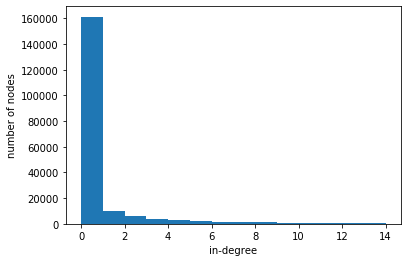

In [110]:
import statistics as stats
degrees = [G.in_degree(n) for n in G.nodes()]
# plt.hist(nx.in_degree_histogram(G), bins=range(10))
plt.hist(degrees, bins=range(15))
for n in range(0, 10):
    print(degrees.count(n))
# print("max is: ",max(degrees))
# print("min is: ",min(degrees))
# print("mean is: ",stats.mean(degrees))
# print("median is: ",stats.median(degrees))

# # plt.hist( x=[ len(ca) for ca in coauthors.values() ], bins=range(60) )
plt.xlabel('in-degree')
plt.ylabel('number of nodes')
# plt.xlim(0,51);


**Answer:** _The histogram appears to follow a decreasing power law, albeit with a huge spike at zero, which is a floor effect as you cannot have less than 0 in_nodes. It's skewed to the right obviously, with the mean larger than the median. What it tells us about the network is that the majority of nodes have no papers citing them at all. Then it follows a decreasing power law, with each extra citation (in_degree) reducing significantly the number of nodes. There are also some outlier super-connector nodes, with high in_degrees, thus important papers cited a lot._

### Task 2

Using the [Link Analysis](https://networkx.github.io/documentation/networkx-1.10/reference/algorithms.link_analysis.html) algorithms provided by NetworkX, calculate the PageRank score for all nodes in the citation network, and store the result in a variable called `pageranks`. Print out the PageRank values for the two example papers given below.
You can also use the `pagerank_scipy` implementation, which tends to be considerably faster than its regular `pagerank` counterpart, for which you have to install the [SciPy package](http://scipy.org/):

In [28]:
! pip install --user scipy

To print and compare PageRank values, you might want to use commands like `print('{:.6f}'.format(var))` to use regular decimal notation with a fixed number of decimal places.

In [81]:
# Add your code here:
pageranks = nx.pagerank_scipy(G)

# print PageRank for paper 26968958
print('PageRank for paper 26968958 is {:.6f}'.format(pageranks[26968958]))

# print PageRank for paper 20923692
print('PageRank for paper 20923692 is {:.6f}'.format(pageranks[20923692]))

PageRank for paper 26968958 is 0.000004
PageRank for paper 20923692 is 0.000059


### Task 3

Why do the two papers above have such different PageRank values? Write code below to investigate and show the cause of this, and then explain the cause of this difference based on the results generated by your code.

In [46]:
# Add your code here
print("Papers in_degree",G.in_degree([26968958, 20923692]))
print("Papers out_degree",G.out_degree([26968958, 20923692]),'\n')

print("Papers citing paper 26968958",papers_citing[26968958])

print("Papers citing paper 20923692",papers_citing[20923692],'\n')

print("Paper 26968958: in_degree of nodes citing ",G.in_degree(papers_citing[26968958]))
print("Paper 26968958: out_degree of nodes citing ",G.out_degree(papers_citing[26968958]),'\n')

print("Paper 20923692: in_degree of nodes citing ",G.in_degree(papers_citing[20923692]))
print("Paper 20923692: out_degree of nodes citing ",G.out_degree(papers_citing[20923692]))

Papers in_degree [(26968958, 10), (20923692, 10)]
Papers out_degree [(26968958, 0), (20923692, 0)] 

Papers citing paper 26968958 [31426616, 31172718, 30828329, 30744105, 30646188, 30263035, 30231558, 30206453, 30151118, 28677354]
Papers citing paper 20923692 [30081920, 29728628, 28889999, 25422088, 24037376, 23378838, 23316260, 22732592, 22139413, 21878358] 

Paper 26968958: in_degree of nodes citing  [(31426616, 0), (31172718, 1), (30828329, 0), (30744105, 3), (30646188, 2), (30263035, 1), (30231558, 6), (30206453, 0), (30151118, 1), (28677354, 4)]
Paper 26968958: out_degree of nodes citing  [(31426616, 112), (31172718, 29), (30828329, 75), (30744105, 98), (30646188, 31), (30263035, 40), (30231558, 48), (30206453, 23), (30151118, 24), (28677354, 37)] 

Paper 20923692: in_degree of nodes citing  [(30081920, 0), (29728628, 0), (28889999, 2), (25422088, 0), (24037376, 209), (23378838, 0), (23316260, 4), (22732592, 0), (22139413, 0), (21878358, 0)]
Paper 20923692: out_degree of nodes cit

**Answer:** [Pagerank is based on the number of papers citing you, and from these papers, they're more important if they themselves are cited often. However, this importance is then shared amongst all of the papers it then cites.
We can see two effects above.
Paper 26968958 with page rank = 0.000004 is cited by 10 papers, and paper 20923692 with page rank = 0.000059 is also cited by 10 papers. So it must be some difference between these papers citing them, if it's not just sheer number of citations differing. Hence, we need to check the importance of each of these groups of 10 papers citing our papers of interest, and then how much that importance is diluted.
For paper 26968958 we can see that the importance of nodes citing it, is not very high, ranging from 0 to 6 with 3 papers having nothing citing. For paper 20923692, 7 papers have nothing citing them, however one paper citing our paper (24037376, 209) is fairly important, as it's cited 209 times.
Then, we look at how diluted the importance of cited papers are. For paper 26968958, we can see that all the papers citing it, cite a lot of papers, ranging from 24 to 112, meaning a strong dilution in the importance it receives. Whereas for paper 20923692, from the papers citing it, they don't cite a lot of papers, ranging from 1 to 17.
It seems the main differtiator, is that Paper 20923692 receives 1/4 of the importance of (24037376, 4), which is an important paper as it's cited 209 times (24037376, 209). This would explain the difference in PageRank values.]

### Task 4

Copy the scoring function `score_ntn` from Task 4 of assignment 3. Rename it to `score_ntn_pagerank` and change its code to incorporate a paper's PageRank score in it's final score, in addition to tf-idf. In other words, the new function should accept a `list` of query tokens and a document ID, and should return a single `float` value that is calculated based on both scores (PageRank and tf-idf). Note that a `tf-idf` function is already provided above. Explain your decision on how to combine the two scores.

In [82]:
def score_ntn_pagerank(query_words, doc_id):
    score = 0
    for word in query_words:
        score += tfidf(word, doc_id)
    score*=pageranks[doc_id]
    return float(score)

**Answer:** _Methods I read about online, involved returning n best documents (e.g. 10 best) from tf-idf, and then sorting this n by their pagerank. However, the strucuture of this assignment precludes that. Therefore, I've chosen to use a weighted scoring that after calculating the sum of tf-idfs for each word in a document, multiplies this score by the pagerank. You could of course adjust this simple weighting, if you wanted to emphasise relevance or importance of documents respectively. However I've no further understanding of information needs at this point to justify that._

### Task 5

Copy the query function `query_ntn` from Task 4 of assignment 3. Rename it to `query_ntn_pagerank` and change the code to use our new scoring function `score_ntn_pagerank` from task 4 above. Demonstrate these functions with an example query that returns paper 19343057 as the top result.

In [78]:
def query_ntn_pagerank(query_string):
    PRINT_TOP_X = 10
    query_words = []
    docs_ranked = {}
    query_words = preprocess(tokenize(query_string))
    doc_matches = set(inverted_index[query_words[0]])
    for i in query_words:
        temp_matches = set()
        for j in inverted_index[i]:
            temp_matches.add(j)
        doc_matches = doc_matches.union(temp_matches)
    for doc in doc_matches:
        docs_ranked[doc] = score_ntn_pagerank(query_words, doc)
    top = 0
    for k, v in sorted(docs_ranked.items(), key=lambda kv: kv[1], reverse=True):
        print("doc id:",k, "score:", v)
        top+=1
        if top == PRINT_TOP_X:
            break
            
query_ntn_pagerank("immunological dysregulation and gut microbiota")

doc id: 19343057 score: 0.030573494712968788
doc id: 12462124 score: 0.010039051862298995
doc id: 16497588 score: 0.008734186859012845
doc id: 15032588 score: 0.005545104293061366
doc id: 21997792 score: 0.0053350522869381875
doc id: 15790845 score: 0.00465109904742401
doc id: 22318520 score: 0.004001171557028238
doc id: 22224781 score: 0.0036162594596571584
doc id: 15608205 score: 0.003503549438092533
doc id: 16602946 score: 0.0033459559723715343


# Submission

Submit the answers to the assignment via Canvas as a modified version of this Notebook file (file with `.ipynb` extension) that includes your code and your answers.

Before submitting, restart the kernel and re-run the complete code (**Kernel > Restart & Run All**), and then check whether your assignment code still works as expected.

Don't forget to add your name, and remember that the assignments have to be done individually and group submissions are **not allowed**.